In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test = pd.read_csv('test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
# Different types of toxic words
train.iloc[:, 2:].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [5]:
# add clean column
row_sum = train.iloc[:, 2:].sum(axis=1)
train['clean'] = (row_sum==0)
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,True
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,False
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,True
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,True
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,True


In [6]:
#Total Comments
len(train)

159571

In [7]:
len(test)

153164

In [8]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64

In [9]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

In [10]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[classes].values

Text(0.5, 0, 'Class')

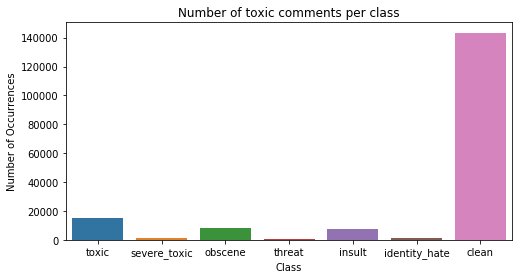

In [11]:
# All toxic classes
train_part = train.iloc[:, 2:].sum()
plt.figure(figsize=(8,4))
sns.barplot(train_part.index, train_part.values)
plt.title("Number of toxic comments per class")
plt.ylabel('Number of Occurrences')
plt.xlabel('Class')

Text(0.5, 0, 'Number of Tags')

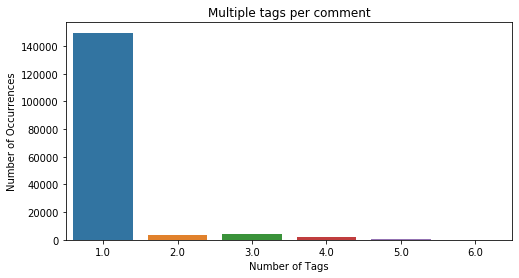

In [12]:
# Checking how many comments have multiple tags
tags_part = train.iloc[:,2:].sum(axis=1).value_counts() 
plt.figure(figsize=(8,4))
sns.barplot(tags_part.index, tags_part.values)
plt.title("Multiple tags per comment")
plt.ylabel('Number of Occurrences')
plt.xlabel('Number of Tags')

In [13]:
# Only ~7% of the total comments have some sort of toxicity in them. There are certain comments(31) that are marked as all of the above!

In [14]:
temp_df=train.iloc[:,2:-1] #except clean column

corr=temp_df.corr()
corr

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


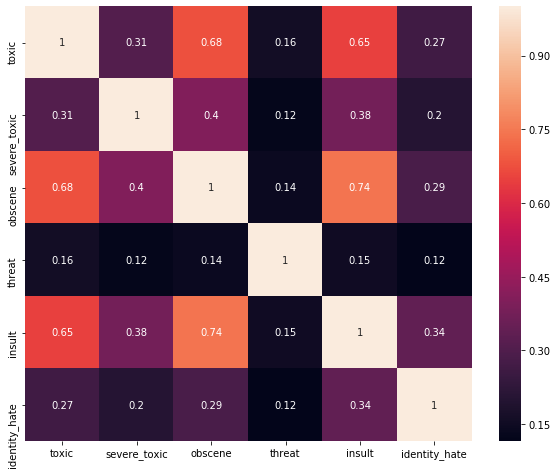

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True)

In [16]:
train_sentences = train["comment_text"].fillna("unknown").str.lower()
test_sentences = test["comment_text"].fillna("unknown").str.lower()

In [17]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer

Using TensorFlow backend.


In [18]:
def tokenization_tweets(dataset, features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

In [19]:
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(6, activation='softmax'))

    model_nn.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=validation,
                 shuffle=shuffle)
    return model_nn

In [20]:
def model1(X_train, y_train):
    features = 3500
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.001
    epsilon = None
    validation = 0.1
    model = train(X_train, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model

In [21]:
train_padding = tokenization_tweets(train_sentences, 1000)
test_padding = tokenization_tweets(test_sentences, 1000)

In [ ]:
model = model1(train_padding, y)

In [316]:
predict = model.predict(test_padding, batch_size=1024, verbose=1)
predict

153164/153164 [==============================] - 2s 12us/step


array([[3.1165940e-01, 9.3087219e-02, 1.9598609e-01, 7.4397013e-02,
        1.8891564e-01, 1.3595460e-01],
       [3.1165940e-01, 9.3087219e-02, 1.9598609e-01, 7.4397013e-02,
        1.8891564e-01, 1.3595460e-01],
       [3.1165588e-01, 9.3097530e-02, 1.9598389e-01, 7.4396171e-02,
        1.8891351e-01, 1.3595307e-01],
       ...,
       [4.4350225e-01, 6.0409438e-03, 2.7933803e-01, 1.3086091e-05,
        2.7087593e-01, 2.2973039e-04],
       [3.1165940e-01, 9.3087219e-02, 1.9598609e-01, 7.4397013e-02,
        1.8891564e-01, 1.3595460e-01],
       [3.1165940e-01, 9.3087219e-02, 1.9598609e-01, 7.4397013e-02,
        1.8891564e-01, 1.3595460e-01]], dtype=float32)

In [239]:
sentiments = [classes[np.argmax(pred)] for pred in predict]

In [241]:
sentiments.count('toxic')

153164